In [10]:
# load the package
include("../FractionalFlow/FractionalFlow.jl")
using PyPlot, SetPyPlot, Dierckx, Statistics, NLopt
import Calculus
import GR
FF = FractionalFlow

Main.FractionalFlow

# Water-flooding

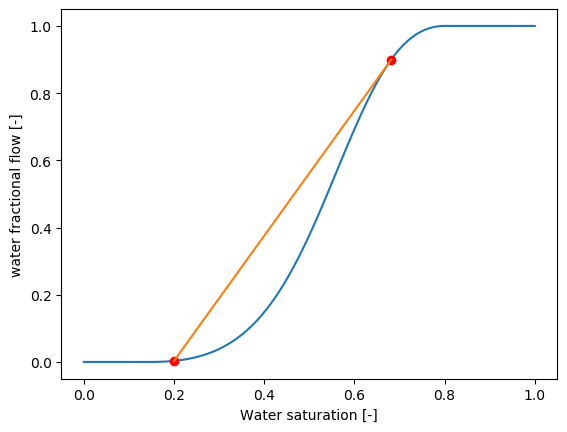

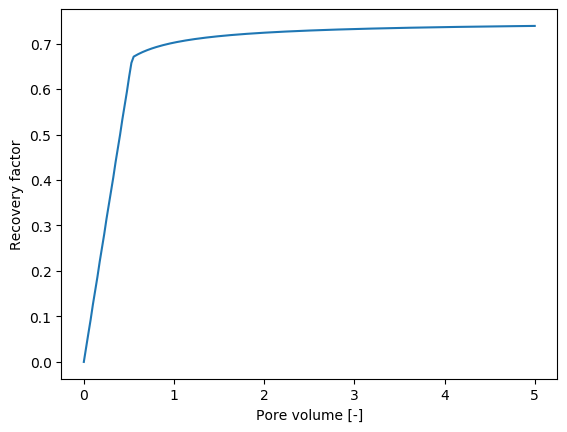

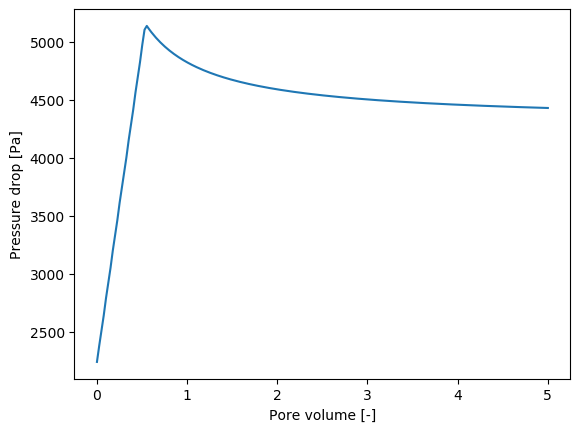

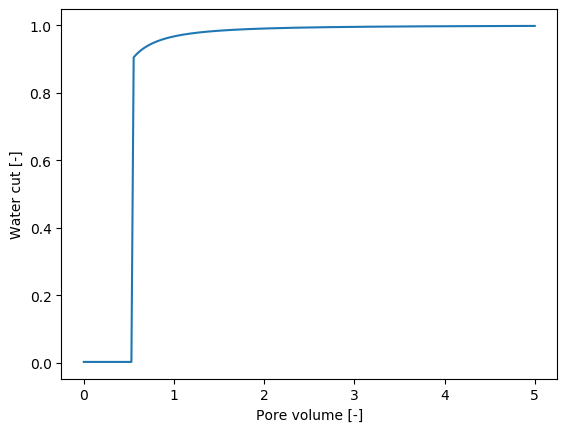

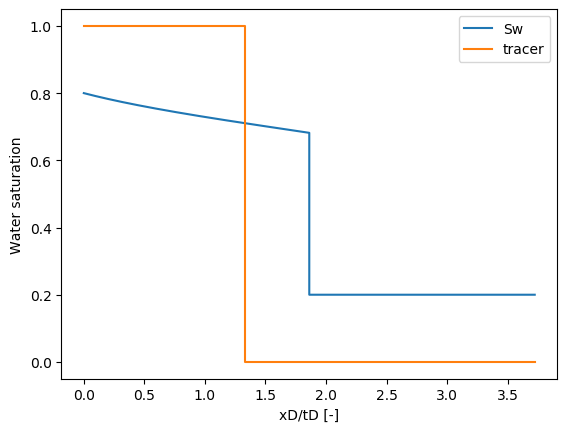

PyObject <matplotlib.legend.Legend object at 0x0000000000EE25F8>

In [11]:
# define the problem
# relative permeabilities
rel_perms = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
    swc=0.15, sor=0.2, nw=2.0, no = 2.0)
# FF.visualize(rel_perms)
# define the fluids
fluids = FF.oil_water_fluids(mu_water=1e-3, mu_oil=1e-3)

# define the fractional flow functions
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
# visualize the fractional flow
# FF.visualize(rel_perms, fluids, label="lowsal")
# tight_layout()
ut = 1.15e-5
phi = 0.3
L = 0.15
core_flood = FF.core_flooding(u_inj=1.15e-5, pv_inject=5, 
    p_back=1e5, sw_init=0.2, sw_inj=1.0, rel_perms=rel_perms)
core_props = FF.core_properties()
wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
sw_tmp = FF.linspace(0,1,100)

FF.visualize(wf_res)

In [12]:
t_sec, pv, rec_fact, dp_core, x, sw_face, c_face, c_out_sal=FF.water_flood_numeric(core_props, fluids, rel_perms, core_flood, Nx=50)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


([0.0, 26.086956521739133, 26.607186199524936, 27.135507511278284, 27.67240634320934, 28.218400516364337, 28.774042266160855, 29.33992094890637, 29.91666599949902, 30.50495016746274  …  5937.3177179224285, 6564.964864736294, 7310.971927867449, 8207.808975006947, 9300.41617919656, 10652.48751343839, 12356.809746482852, 14552.934447722162, 17458.74357803524, 19565.217391304348], [0.0, 0.006666666666666668, 0.006799614250989706, 0.006934629697326673, 0.007071837176597942, 0.0072113690208486635, 0.007353366356907773, 0.0074979797980538505, 0.0076453701998719726, 0.0077957094872404785  …  1.5173145279135094, 1.6777132432103863, 1.868359492677237, 2.0975511825017756, 2.3767730235724542, 2.7223023645453663, 3.1578513796567287, 3.7190832477512195, 4.461678914386783, 5.0], [0.0, 0.008307692307685011, 0.008473365451226038, 0.008641615468969048, 0.008812597096983947, 0.008986475241357903, 0.009163425767831633, 0.009343636363721174, 0.009527307479832943, 0.009714653361015308  …  0.7125107850115477

# synthetic experimental data


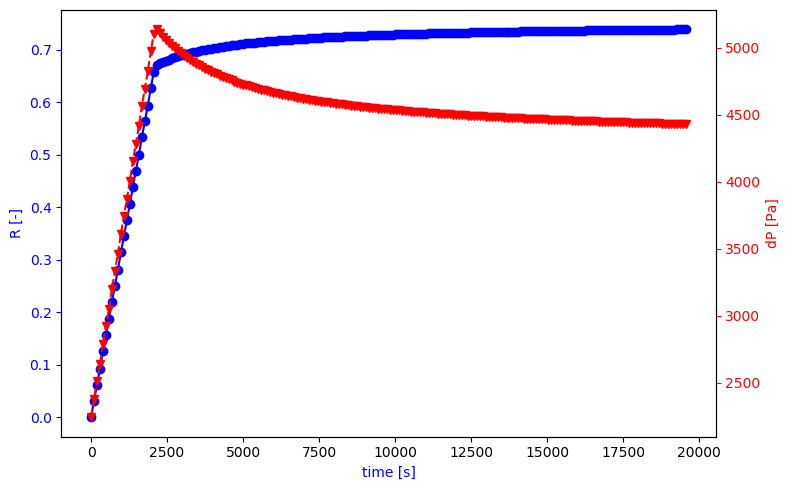

(Figure(PyObject <Figure size 800x500 with 2 Axes>), PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x0000000000F02EB8>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x000000002B303C18>)

In [13]:
t_exp_dp = wf_res.dp_time[:,1]
dp_exp = wf_res.dp_time[:,2]
t_exp_R = wf_res.recovery_time[:,1]
R_exp = wf_res.recovery_time[:,2]
plotyy(t_exp_R, R_exp, t_exp_dp, dp_exp, fig_size = [8,5], x_label="time [s]", y1_label="R [-]", y2_label="dP [Pa]")

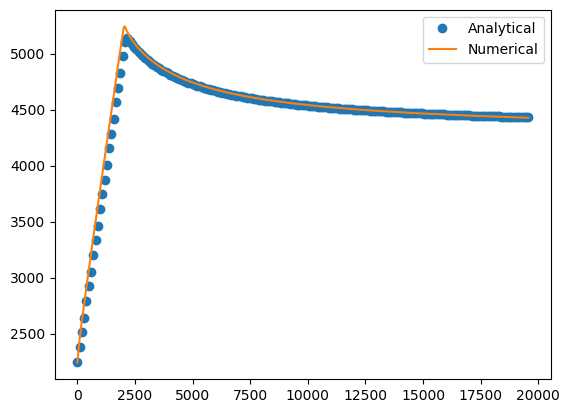

PyObject <matplotlib.legend.Legend object at 0x000000002B181390>

In [14]:
plot(t_exp_dp, dp_exp, "o", t_sec, dp_core)
legend(["Analytical", "Numerical"])

# define the objective function

In [15]:
# struct
struct exp_data
    t_exp_dp
    dp_exp
    t_exp_R
    R_exp
end
exp_data1 = exp_data(t_exp_dp, dp_exp, t_exp_R, R_exp)

exp_data(Real[0.0, 98.31767533318768, 196.63535066637536, 294.953025999563, 393.2707013327507, 491.58837666593837, 589.906051999126, 688.2237273323137, 786.5414026655014, 884.8590779986891  …  18680.35831330566, 18778.675988638846, 18876.993663972033, 18975.311339305223, 19073.62901463841, 19171.946689971595, 19270.264365304785, 19368.58204063797, 19466.89971597116, 19565.217391304348], Real[2242.5, 2382.128775673707, 2512.9953521661364, 2643.8423673312104, 2792.5201557768337, 2923.3335362920134, 3054.1548119246854, 3202.8353234859637, 3333.644906448923, 3464.460588605819  …  4436.691912494659, 4436.071639197636, 4435.457548034828, 4434.849537166554, 4434.247520718975, 4433.651413110157, 4433.061124183338, 4432.476569199722, 4431.89766279601, 4431.32432788954], Real[0.0, 98.31767533318768, 196.63535066637536, 294.953025999563, 393.2707013327507, 491.58837666593837, 589.906051999126, 688.2237273323137, 786.5414026655014, 884.8590779986891  …  18680.35831330566, 18778.675988638846, 18876

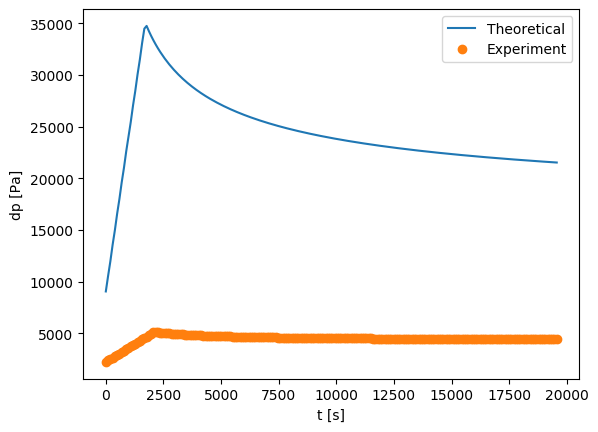

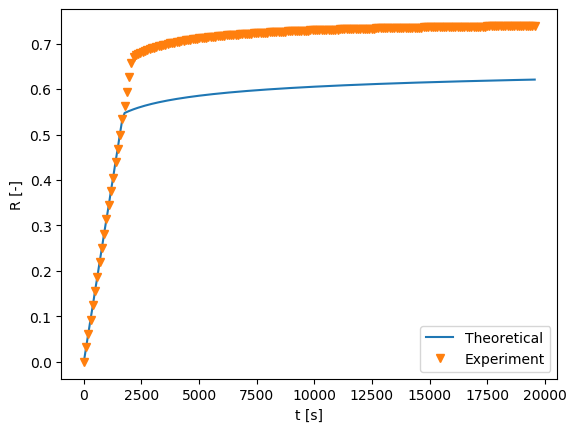

19.9464158414438

In [16]:
"""
rel_perm_param [krw0, kro0, nw, no, swc, sor]
"""
function error_calc(rel_perm_param, exp_data, core_props, fluids, core_flood; w_p=1.0, w_R=1.0)
    rel_perms = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
    wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
    dp_calc = Spline1D(wf_res.dp_time[:,1], wf_res.dp_time[:,2], k=1, bc="nearest")
    R_calc = Spline1D(wf_res.recovery_time[:,1], wf_res.recovery_time[:,2], k=1, bc="nearest")
    error_dp = abs.(dp_calc(exp_data.t_exp_dp) .- exp_data.dp_exp)
#     println(error_dp)
    error_R = abs.(R_calc(exp_data.t_exp_R) .- exp_data.R_exp)
#     println(error_R)
    error_dp_norm = w_p.*error_dp./exp_data.dp_exp
    error_R_norm = w_R.*error_R./(exp_data.R_exp.+eps())
    return mean(error_R_norm.^2)+mean(error_dp_norm.^2)
end

function vis_error(rel_perm_param, exp_data, core_props, fluids, core_flood)
    rel_perms = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
    wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
    figure()
    plot(wf_res.dp_time[:,1], wf_res.dp_time[:,2],  exp_data.t_exp_dp, exp_data.dp_exp, "o")
    xlabel("t [s]")
    ylabel("dp [Pa]")
    legend(["Theoretical", "Experiment"])
    
    figure()
    plot(wf_res.recovery_time[:,1], wf_res.recovery_time[:,2], exp_data.t_exp_R, exp_data.R_exp, "v")
    xlabel("t [s]")
    ylabel("R [-]")
    legend(["Theoretical", "Experiment"])
    
end

# test
x_init = [0.109681, 0.201297, 3.96653, 3.0, 0.19, 0.262231]

vis_error(x_init, exp_data1, core_props, fluids, core_flood)
error_calc(x_init, exp_data1, core_props, fluids, core_flood)

# define the objective function and gradients and weight factors

In [17]:
# weight factors:
w_p = ones(length(exp_data1.dp_exp))
temp_val, ind_max = findmax(exp_data1.dp_exp)
println(ind_max)
w_p[ind_max-1:ind_max+1] .= 50
w_p[end:end-10] .= 50
w_p[1]=50
w_R = ones(length(exp_data1.R_exp))
w_R[20:25] .= 1
w_R[end:end-3] .= 50


function f(x)
    f_val = 0.0
    try
        f_val = error_calc(x, exp_data1, core_props, fluids, core_flood, w_p = w_p, w_R = w_R)
    catch
        f_val = 100.0
#         info("Objective function did not converge!")
    end
    return f_val
end

    
function g(x)
    eps1 = 1e-4
    f_val = f(x)
    g_val = ones(length(x))
    try
        # g_val = Calculus.gradient(x -> error_calc(x, exp_data1, core_props, fluids, core_flood), x)
        for j in eachindex(x)
            x2 = copy(x)
            x2[j]+=eps1
            f_val2 = f(x2)
            g_val[j] = (f_val2-f_val)/eps1
        end
    catch
        g_val = ones(length(x))
    end
    return g_val
end

function obj_fun(param, grad)
    if length(grad)>0
      grad[:] = g(param)
    end
    
    obj_fun_val = f(param)
    if isnan(obj_fun_val) || isinf(obj_fun_val)
        obj_fun_val = 100.0
    end
    return obj_fun_val
end

# test
grad_x = zeros(6)
obj_fun([1.0, 0.8, 3, 4, 0.2, 0.2], grad_x)

f([1.0, 0.8, 2, 2, 0.1, 0.2])

23


10.276053430154226

In [18]:
grad_x

6-element Array{Float64,1}:
 -4.452510502568341 
 -1.1519360498385423
  1.130193570705318 
  1.2900613408245443
 -2.3370195788252612
 -2.417209148277699 

In [19]:
## algorithms
# L: Local, G:global
# D: derivative-based, N: non-derivative (search-based)

# :LD_MMA
# :LN_COBYLA
# :LD_LBFGS
# :GN_DIRECT
# :GN_DIRECT_L
# GN_CRS2_LM
# G_MLSL_LDS
# GD_STOGO
# GN_ISRES
# GN_ESCH
# LN_NEWUOA_BOUND
# LN_BOBYQA
# LN_PRAXIS
# LN_NELDERMEAD
# LN_SBPLX
# LD_SLSQP
# LD_TNEWTON_PRECOND_RESTART
# LD_TNEWTON_RESTART
# LD_TNEWTON_PRECOND


In [20]:
x_init = [0.9, 0.8, 2.5, 2.5, 0.1, 0.1]
x_lb = [0.1, 0.1, 1.5, 1.5, 0.05, 0.1]
x_ub = [1.0, 1.0, 4.0, 4.0, core_flood.initial_water_saturation, 0.25]
opt_alg=:LN_COBYLA
opt1 = Opt(opt_alg, length(x_init)) # choose the algorithm
lower_bounds!(opt1, x_lb)
upper_bounds!(opt1, x_ub)
ftol_rel!(opt1, 1e-15)
ftol_abs!(opt1, 1e-15)

min_objective!(opt1, obj_fun)
(fObjOpt, paramOpt, flag) = optimize(opt1, x_init)

(0.05742739596353891, [0.9351495576303033, 0.9333127646589925, 3.4121770386318, 3.2906318769166085, 0.1580557067988788, 0.10567547928430192], :FTOL_REACHED)

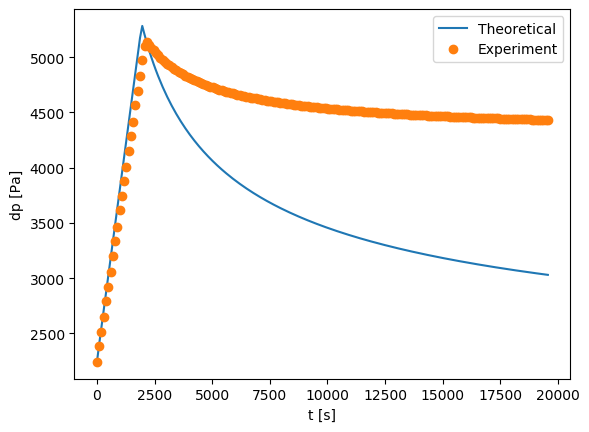

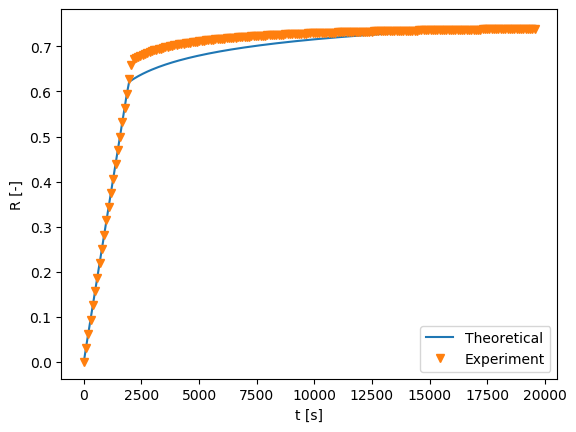

0.05163250696528693

In [21]:
x_init = paramOpt
vis_error(x_init, exp_data1, core_props, fluids, core_flood)
error_calc(x_init, exp_data1, core_props, fluids, core_flood)

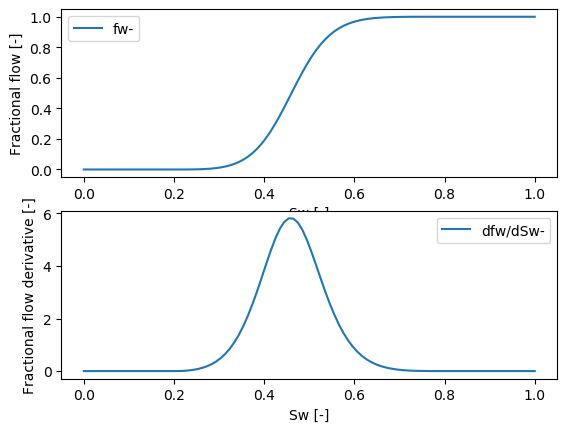

PyObject <matplotlib.legend.Legend object at 0x0000000001702550>

In [22]:
rel_perm_param=[1.0, 0.8, 3, 4, 0.2, 0.2]
rel_perms2 = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
FF.visualize(rel_perms2, fluids)

# Using JuMP
I'm going to try and use [JuMP](https://github.com/JuliaOpt/JuMP.jl) for history matching of core flooding data. I have used it previously for the history matching of foam flooding, but this is slightly different because there I ony had steady state data and did not need to solve a differential equation. Moreover, I could use automatic differentiation that is not possible to use here. 

In [30]:
using JuMP, Ipopt

In [41]:
# weight factors:
w_p = ones(length(exp_data1.dp_exp))
temp_val, ind_max = findmax(exp_data1.dp_exp)
println(ind_max)
w_p[ind_max-1:ind_max+1] .= 1
w_p[end:end-10] .= 100
w_p[1]=1
w_R = ones(length(exp_data1.R_exp))
w_R[20:25] .= 1
w_R[end:end-3] .= 1

# [krw0, kro0, nw, no, swc, sor]

function my_f(krw0, kro0, nw, no, swc, sor)
    f_val = error_calc([krw0, kro0, nw, no, swc, sor], exp_data1, core_props, 
            fluids, core_flood, w_p = w_p, w_R = w_R)
    return f_val
end

function ∇f(g_val, krw0, kro0, nw, no, swc, sor)
    eps1 = 1e-4
    x = [krw0, kro0, nw, no, swc, sor]
    f_val = my_f(krw0, kro0, nw, no, swc, sor)
    g_val = zeros(length(x))
    for j in eachindex(x)
        x2 = copy(x)
        x2[j]+=eps1
        f_val2 = my_f(x2...)
        g_val[j] = (f_val2-f_val)/eps1
    end
    return g_val
end

# test
grad_x = zeros(6)
my_f(1.0, 0.8, 3, 4, 0.2, 0.2)

∇f(1.0, 0.8, 2, 2, 0.1, 0.2)

23


6-element Array{Float64,1}:
  0.39751429274204053
  0.08125228498301329
 -0.03157883671778272
 -0.11145312971860832
  0.06392808676480843
  0.15022455964519565

In [42]:
model = Model(with_optimizer(Ipopt.Optimizer, print_level=1))

@variable(model, 0.1 <= kro0 <= 1.0)
@variable(model, 0.1 <= krw0 <= 1.0)
@variable(model, 0.01 <= sor <= 0.4)
@variable(model, 0.01 <= swc <= 0.4)
@variable(model, 1.0 <= no <= 4.0)
@variable(model, 1.0 <= nw <= 4.0)

register(model, :my_f, 6, my_f, ∇f)

@NLobjective(model, Min, my_f(krw0, kro0, nw, no, swc, sor))

# JuMP.register(model::Model, s::Symbol, dimension::Integer, f::Function,
#               ∇f::Function, ∇²f::Function)
# my_f(x, y) = (x - 1)^2 + (y - 2)^2
# function ∇f(g, x, y)
#     g[1] = 2 * (x - 1)
#     g[2] = 2 * (y - 2)
# end
JuMP.optimize!(model)

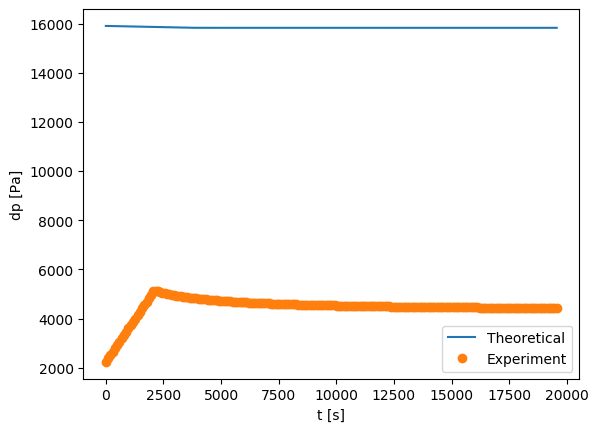

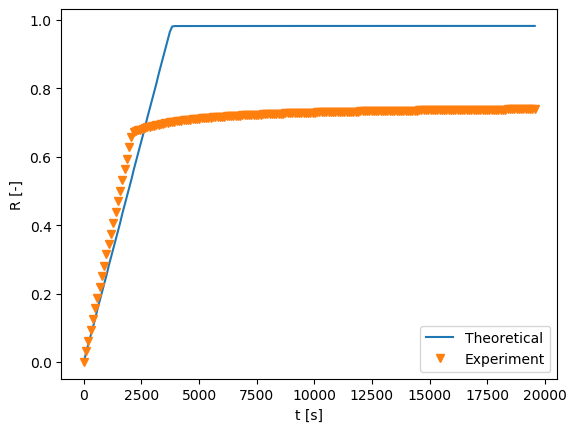

7.0655739507367255

In [43]:
x_init = [value(krw0), value(kro0), value(nw), value(no), value(swc), value(sor)]
vis_error(x_init, exp_data1, core_props, fluids, core_flood)
error_calc(x_init, exp_data1, core_props, fluids, core_flood)

In [38]:
x_init

6-element Array{Float64,1}:
 0.10900106410345307 
 0.10900106410345307 
 1.0100010569792714  
 1.0100010569792714  
 0.013901213805209279
 0.013901213805209279